# Завдання

_Вправа 1: натренуйте модель дерева рішень та виконайте пошук гіперпараметрів для moons dataset._ \
a. Згенеруйте датасет, використовуючи функцію `make_moons(n_samples=10000, noise=0.4)`. \
b. Розбийте її на тренувальну та тестувальну частини, використовуючи функцію `train_test_split()`. \
c. Використайте пошук з крос-валідацією (`GridSearchCV`, `RandomizedSearchCV`) для пошуку гіперпараметрів моделі `DecisionTreeClassifier`. Зокрема, спробуйте різні значення для параметра `max_leaf_nodes`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import tree
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from matplotlib.colors import ListedColormap


In [2]:
def plot_decision_boundaries(
        clf, X, ax=None, resolution=300, cmap=plt.cm.coolwarm, alpha=0.3
):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=alpha, cmap=cmap)
    return ax

def print_search_results(bp: dict) -> None:
    print(
    f"Best score: {search_model.best_score_}\n"
    f"Best params:\n"
    f"\tmax_depth:{bp['max_depth']}\n"
    f"\tmin_samples_split:{bp['min_samples_split']}\n"
    f"\tmin_samples_leaf:{bp['min_samples_leaf']}\n"
    f"\tmax_leaf_nodes:{bp['max_leaf_nodes']}"
    )

In [3]:
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [4]:
X_0, X_1 = X[y == 0], X[y == 1]
print(X_0.shape, X_1.shape)
print(
    X_train[y_train == 0].shape,
    X_train[y_train == 1].shape
)

(5000, 2) (5000, 2)
(3987, 2) (4013, 2)


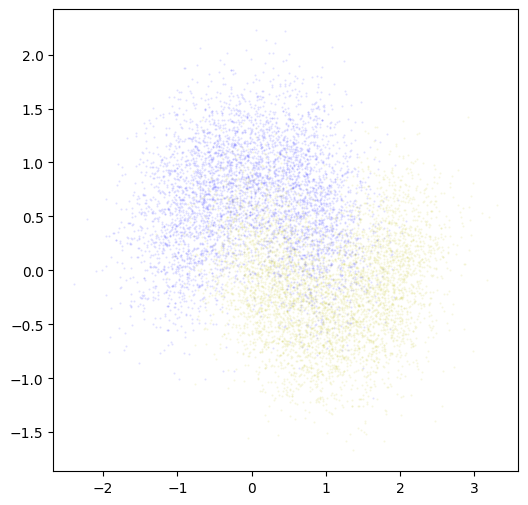

In [5]:
def plot_points(X_0, X_1, ax=None, alpha=0.1):
    X_0, X_1 = X_0.T, X_1.T
    getattr(ax or plt, "scatter")(X_0[0], X_0[1], 0.3, "b", alpha=alpha)
    getattr(ax or plt, "scatter")(X_1[0], X_1[1], 0.3, "y", alpha=alpha)


plt.figure(figsize=(6, 6))
plot_points(X_0, X_1)
plt.show()

0.857125
0.8615


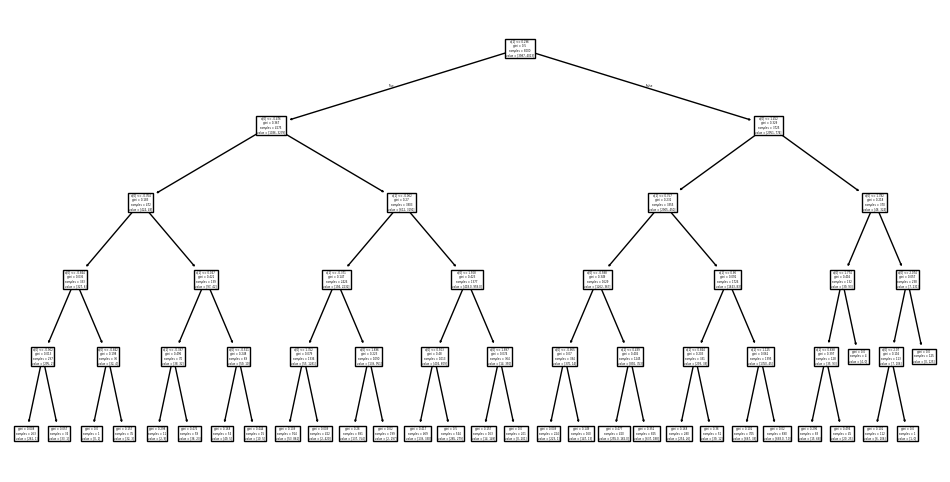

In [6]:
dt_classifier = DecisionTreeClassifier(
    random_state=42,
    max_depth=5
)
dt_classifier.fit(X_train, y_train)
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
plt.figure(figsize=(12, 6))
tree.plot_tree(dt_classifier)
plt.show()

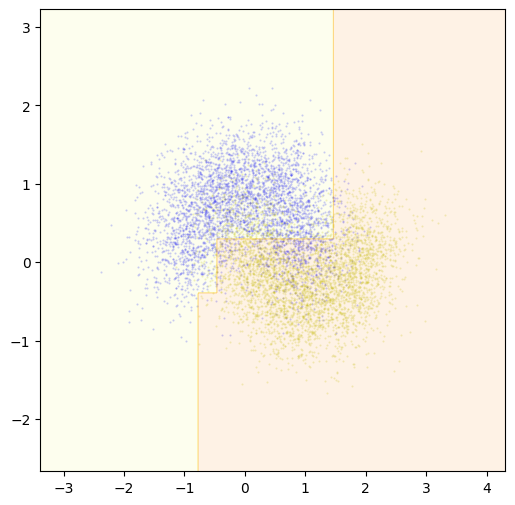

In [7]:
X_0_train, X_1_train = X_train[y_train == 0], X_train[y_train == 1]
X_0_test, X_1_test = X_test[y_test == 0], X_test[y_test == 1]
fig, ax = plt.subplots(figsize=(6, 6))
plot_points(X_0_train, X_1_train, ax, alpha=0.2)
plot_decision_boundaries(
    dt_classifier, X_train, ax=ax, alpha=0.1,
    cmap=plt.cm.Wistia
)
plt.show()

In [8]:
import warnings

warnings.filterwarnings(action="ignore")
search_model = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    {
        "min_samples_split": (1, 3, 5, 8),
        "min_samples_leaf": (12, 15, 16, 17, 20),
        "max_depth": (2, 5, 8, 10, 12),
        "max_leaf_nodes": (18, 22, 24, 26, 28)
    },
    n_jobs=-1,
    cv=5,
    scoring="accuracy",
)
search_model.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': (2, ...), 'max_leaf_nodes': (18, ...), 'min_samples_leaf': (12, ...), 'min_samples_split': (1, ...)}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [9]:
print_search_results(search_model.best_params_)
print(f"Test split accuracy: {accuracy_score(y_test, search_model.predict(X_test))}")


Best score: 0.859125
Best params:
	max_depth:8
	min_samples_split:3
	min_samples_leaf:16
	max_leaf_nodes:22
Test split accuracy: 0.873


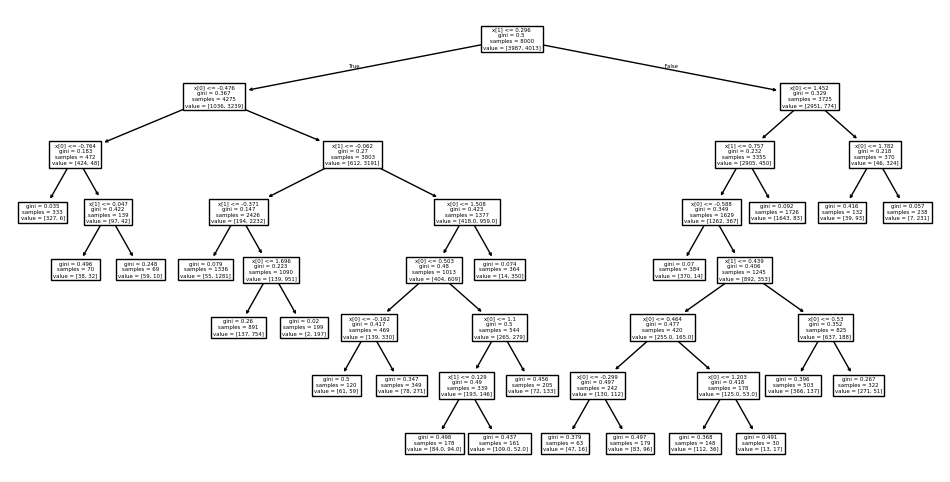

In [10]:
dtc_best = search_model.best_estimator_
dtc_best.fit(X_train, y_train)
plt.figure(figsize=(12, 6))
tree.plot_tree(dtc_best)
plt.show()

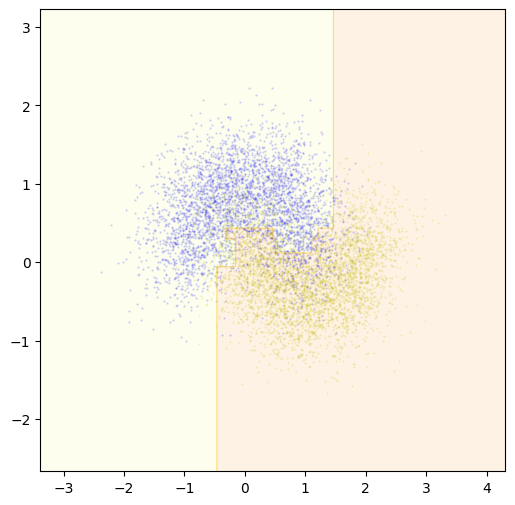

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_points(X_0_train, X_1_train, ax, alpha=0.2)
plot_decision_boundaries(
    search_model, X_train, ax=ax, alpha=0.1,
    cmap=plt.cm.Wistia
)
plt.show()

In [12]:
help(RandomizedSearchCV)

Help on class RandomizedSearchCV in module sklearn.model_selection._search:

class RandomizedSearchCV(BaseSearchCV)
 |  RandomizedSearchCV(
 |      estimator,
 |      param_distributions,
 |      *,
 |      n_iter=10,
 |      scoring=None,
 |      n_jobs=None,
 |      refit=True,
 |      cv=None,
 |      verbose=0,
 |      pre_dispatch='2*n_jobs',
 |      random_state=None,
 |      error_score=nan,
 |      return_train_score=False
 |  )
 |
 |  Randomized search on hyper parameters.
 |
 |  RandomizedSearchCV implements a "fit" and a "score" method.
 |  It also implements "score_samples", "predict", "predict_proba",
 |  "decision_function", "transform" and "inverse_transform" if they are
 |  implemented in the estimator used.
 |
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated search over parameter settings.
 |
 |  In contrast to GridSearchCV, not all parameter values are tried out, but
 |  rather a fixed number of parameter settings is

In [13]:
rsearch_model = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    {
        "min_samples_split": randint(1,12),
        "min_samples_leaf": randint(6,22),
        "max_depth": randint(2,16),
        "max_leaf_nodes": randint(14,30)
    },
    n_jobs=-1,
    cv=5,
    scoring="accuracy",
    n_iter=20,
)
rsearch_model.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_distributions,"{'max_depth': <scipy.stats....0026D28578F50>, 'max_leaf_nodes': <scipy.stats....0026D2855F820>, 'min_samples_leaf': <scipy.stats....0026D28578A50>, 'min_samples_split': <scipy.stats....0026D2856B0E0>}"
,n_iter,20
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [14]:
print_search_results(rsearch_model.best_params_)
print(f"Test split accuracy: {accuracy_score(y_test, search_model.predict(X_test))}")


Best score: 0.859125
Best params:
	max_depth:11
	min_samples_split:6
	min_samples_leaf:16
	max_leaf_nodes:22
Test split accuracy: 0.873


In [16]:
# just to compare with basic GridSearchSV results
print_search_results(search_model.best_params_)

Best score: 0.859125
Best params:
	max_depth:8
	min_samples_split:3
	min_samples_leaf:16
	max_leaf_nodes:22


_Вправа 2_ : \
a. Завантажте датасет MNIST та розбийте його на тренувальну, валідаційну та тестувальну частини (наприклад, 50 000 / 10 000 / 10
000). \
b. Натренуйте різні класифікаційні моделі (Random Forest classifier, Logistic Regression, SVM). \
c. Далі, об'єднайте їх за допомогою голосування. \
d. Натренуйте нову модель, використовуючи виходи попередніх моделей на валідаційній вибірці (це будуть нові ознаки і нова тренувальна вибірка для даної моделі). Протестуйте отриманий ланцюжок на тренувальний вибірці. Такий спосіб поєднання моделей називається стогуванням (stacking).  

In [15]:
# from sklearn.datasets import fetch_openml
#
# mnist = fetch_openml('mnist_784', version=1, cache=True)
#
# X = mnist["data"]
# y = mnist["target"].astype(np.uint8)
#
# X_train = X[:50000]
# y_train = y[:50000]
# X_test = X[60000:]
# y_test = y[60000:]
#
# X_val = X[50000:60000]
# y_val = y[50000:60000]